In [1]:
import jax
import numpy as np
import wandb
import matplotlib.pyplot as plt
from collections import defaultdict

from config import config
from tensorneat.algorithm.hyperneat import FullSubstrate, MLPSubstrate, DefaultSubstrate
from substrate_generation.pca_coor_generator import PCAanalyzer 
from substrate_generation.pca_inv_coor_generator import InvPCAanalyzer 
from substrate_generation.sdl_coor_generator import SparseDictionaryAnalyzer
from substrate_generation.fa_coor_generator import FactorAnalyzer
from substrate_generation.manual_coor_generator import ManualIOMapper
from substrate_generation.random_coor_generator import RandomCoordinateGenerator
from substrate_generation.data_sampling import collect_random_policy_data, collect_trained_agent_policy_data
from evol_pipeline.brax_env import CustomBraxEnv
from evol_pipeline.custom_pipeline import CustomPipeline
from evol_pipeline.custom_substrate import AutoLayeredCoordMLPSubstrate
from substrate_generation.hidden_layers import HiddenLayerGenerator
from utils.visualization import visualize_cppn, visualize_nn, display_plots_side_by_side
from utils.utils import save_coordinates_to_csv, setup_folder_structure
from evol_pipeline.evol_algorithm import create_evol_algorithm

In [2]:
OUTPUT_DIR = config["experiment"]["output_dir"]
setup_folder_structure(OUTPUT_DIR)

In [ ]:
env_name = config["experiment"]["env_name"]
env_problem = CustomBraxEnv(
    env_name=env_name,
    backend=config["environment"]["backend"],
    brax_args=config["environment"]["brax_args"],
    max_step=config["environment"]["max_step"],
    repeat_times=config["environment"]["repeat_times"],
    obs_normalization=False,
    sample_episodes=16,
)
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]
feature_dims = config["data_analysis"]["feature_dims"][1]

print("env_problem.input_shape: ", env_problem.input_shape)
print("env_problem.input_shape: ", env_problem.output_shape)

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
2025-10-19 19:39:19.805135: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-19 19:39:31.288660: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by usin

env_problem.input_shape:  (27,)
env_problem.input_shape:  (8,)


In [4]:
key = jax.random.PRNGKey(config["experiment"]["seed"]) # Use seed from config
key, random_key = jax.random.split(key)
num_random_sampling_steps = 5000
random_data = collect_random_policy_data(env_problem, random_key, num_random_sampling_steps)

Starting data collection for 5000 steps using a random policy...


2025-10-19 19:39:37.670150: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-19 19:39:37.670165: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Causal data collection finished.


In [5]:
variance = config["data_analysis"]["variance_threshold"]
percentage = int(variance*100)

print(f"Analyzing random sampling data")
analyzer_pca = PCAanalyzer(
    data=random_data, 
    obs_size=obs_size, 
    act_size=act_size,
    variance_threshold=variance, 
    feature_dims=feature_dims,
    hidden_depth=config["substrate"]["hidden_depth"],
    width_factor=config["substrate"]["width_factor"],
    normalize_coors=config["data_analysis"]["normalize_coors"],
    depth_factor=config["substrate"]["depth_factor"],
)
input_coors, output_coors = analyzer_pca.generate_io_coordinates()
analyzer_pca.plot_variance(save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_random.png")
analyzer_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_random.png")
print("\n")

Analyzing random sampling data
Running PCA to find feature dimensions covering 65.0% of variance (with a hard limit of 8 dimensions)...
PCA found 15 dimensions needed for 65.0% variance.
Applying max limit. Final number of feature dimensions: 8
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
PCA variance plot saved to: output/ant/data_analysis/pca_variance_65_random.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_65_random.png




In [6]:
hidden_layer_gen = HiddenLayerGenerator(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
    depth_factor=config["substrate"]["depth_factor"],
    width_factor=config["substrate"]["width_factor"],
)

substrates = defaultdict(lambda: defaultdict(dict))

In [7]:
hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)

active_substrate = FullSubstrate(
    input_coors=input_coors,
    hidden_coors=hidden_coors,
    output_coors=output_coors
)


Intial CPPN Layers: [2]


wandb: Currently logged in as: wirkelzirkel (wirkelzirkel-iu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


save to output/ant
initializing
initializing finished
start compile
compile finished, cost time: 36.872047s
Generation: 1, Cost time: 33870.00ms
 	fitness: valid cnt: 3500, max: 52.8329, min: -3957.4614, mean: -1306.2207, std: 1250.6062

	node counts: max: 22, min: 20, mean: 21.27
 	conn counts: max: 40, min: 18, mean: 37.94
 	species: 20, [25, 74, 58, 14, 26, 14, 1, 4, 37, 11, 19, 13, 16, 40, 6, 3, 9, 12, 26, 3092]

Generation: 2, Cost time: 33865.72ms
 	fitness: valid cnt: 3500, max: 55.1128, min: -3952.8345, mean: -398.6121, std: 910.6996

	node counts: max: 23, min: 19, mean: 21.63
 	conn counts: max: 42, min: 0, mean: 38.10
 	species: 20, [189, 25, 185, 162, 142, 1, 138, 5, 34, 25, 88, 28, 86, 61, 61, 40, 15, 28, 7, 2180]

Generation: 3, Cost time: 33904.19ms
 	fitness: valid cnt: 3500, max: 74.9062, min: -3950.9536, mean: -113.7718, std: 562.9756

	node counts: max: 24, min: 20, mean: 21.80
 	conn counts: max: 44, min: 18, mean: 38.41
 	species: 20, [266, 243, 21, 172, 175, 194, 

compute_ms,▇▆▆▆▁▁▁▂▂▂▃▂▃▃▂▃▂▃▃▃▃▃▅▅▅▆▅▆▆▆▇▇▆▇▆▇▇▇██
compute_ms_pop,▅▅▅▆▆▁▂▁▁▂▂▂▃▂▃▃▃▃▃▃▅▅▅▅▅▅▆▅▆▅▆▅▅▆▆▆▆▇▇█
fitness_max,▁▁▄▃▄▄▅▆▆▆▆▆▇▆▆▇▆▇▆▇▇▇▇▇▇▇█▇▇▇███▇▇███▇█
fitness_mean,▁▆▇█████████████████████████████████████
fitness_min,▁▁▁▁▁▁▁▁▂▁▁▂▆▂▁▃▆▁▁▁▁▁▁▆▁▆▁▁▆▁▁▁▂▁▁█▆▆▁▁
fitness_std,█▄▂▂▂▂▂▃▃▃▃▂▂▂▂▁▂▁▂▂▃▃▂▂▂▃▄▂▃▂▄▃▃▂▂▃▂▃▃▃
generation,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
num_species,█████████████▅███████▁████████▅▁██▅███▅█
compute_ms,34180.25255
compute_ms_pop,9.76579
fitness_max,589.8783


Total reward:  609.38007


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/video/agent_random_pca_test.mp4
Visualizing CPPN. Saving to output/ant/topology/cppn_random_pca_test.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 1792 potential connections.
Visualizing 673 connections. Excluded loops. Weight threshold: 0.005


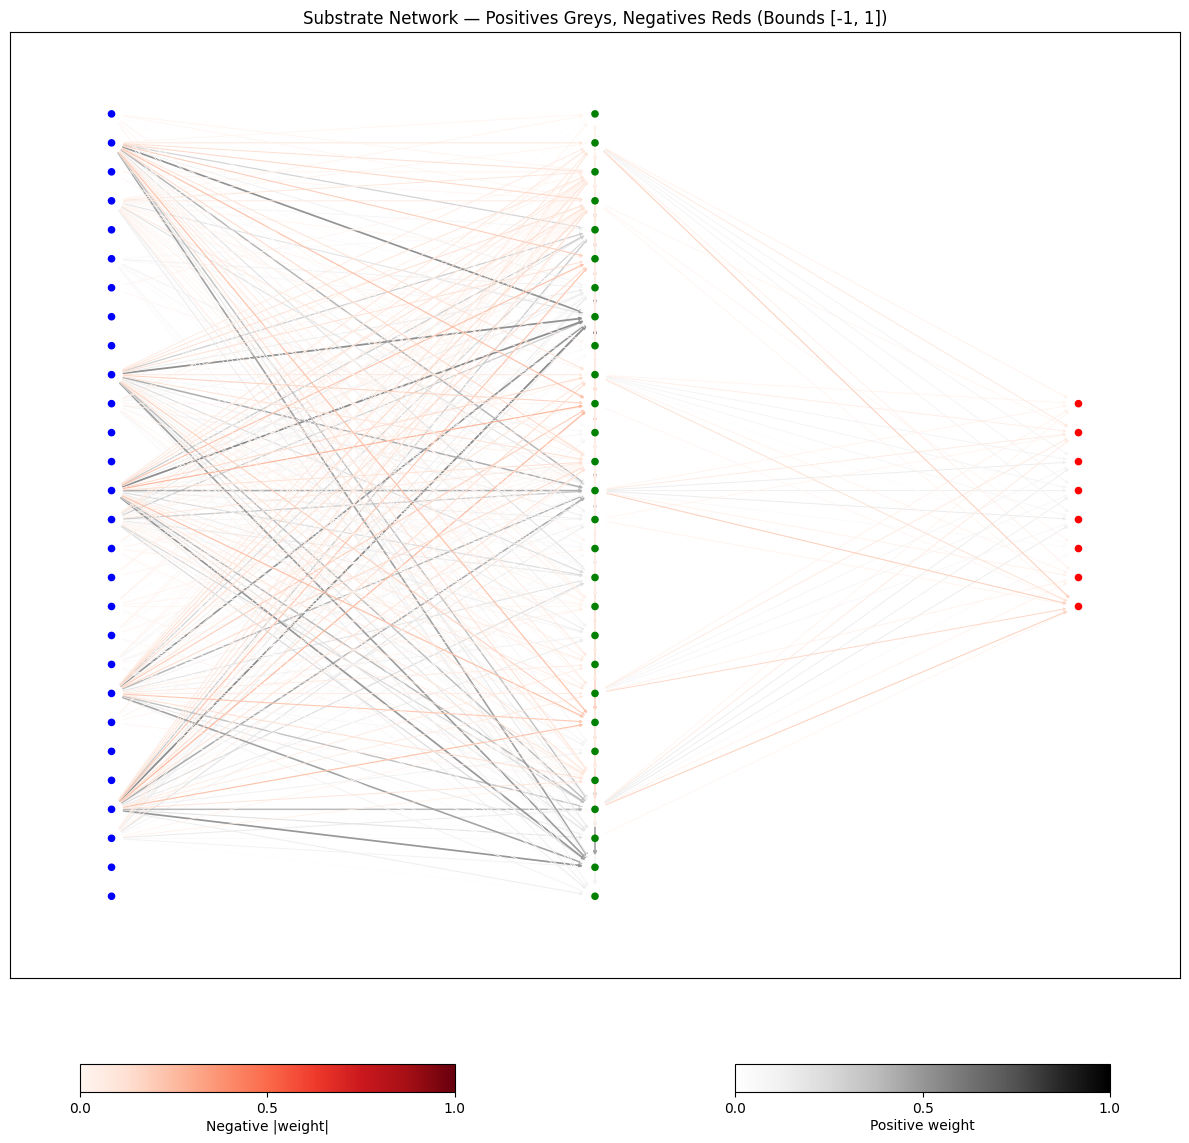

Visualization saved to: output/ant/topology/nn_random_pca_test_.svg
Successfully saved coordinates to: output/ant/coordinates/random_pca_test__io.csv


In [8]:

evol_algorithm = create_evol_algorithm(substrate=active_substrate)

initial_cppn_layers = config["algorithm"]["genome"]["cppn_init_hidden_layers"](active_substrate.query_coors.shape[1])
print("Intial CPPN Layers:", initial_cppn_layers)

substrate_dimensions = int(active_substrate.query_coors.shape[1]/2)

wanbd_name = f"{env_name}_random_pca{percentage}_test_{substrate_dimensions}d"
wandb_tags = [config["substrate"]["hidden_layer_type"], env_name, "pca", "random", "test", f"{config['substrate']['hidden_depth']}_hl", f"{config['algorithm']['neat']['pop_size']}pop", f"{config['environment']['backend']}"]

wandb.init(
    name=wanbd_name,
    project="substrate_dims",
    tags=wandb_tags,
    config=config  
)

wandb.config.update(
    {
        "substrate": {
            "obs_size": obs_size,
            "act_size": act_size,
            "num_queries": active_substrate.query_coors.shape[0],
            "query_dim": active_substrate.query_coors.shape[1],
            },
        "algorithm": {
            "neat": {
                "num_inputs": evol_algorithm.num_inputs,
                },
            "genome": {
                "cppn_init_hidden_layers": initial_cppn_layers,
                },
            },
    },
)


pipeline = CustomPipeline(
    algorithm=evol_algorithm,
    problem=env_problem,
    seed=config["experiment"]["seed"],
    generation_limit=config["pipeline"]["generation_limit"],
    fitness_target=config["pipeline"]["fitness_target"],
    is_save=True,
    save_dir=config["experiment"]["output_dir"],
)

init_state = pipeline.setup()
state = pipeline.auto_run(state=init_state)

print(f"\nTraining finished. Best fitness achieved: {pipeline.best_fitness}")

wandb.finish()

state_for_show = state[0] if isinstance(state, tuple) else state

# Transform the best genome into network parameters
best_genome = pipeline.best_genome

# Built-in show method to produce and save a video of the agent
pipeline.show(
    state=state_for_show,
    best=best_genome,
    output_type="mp4",
    save_path=f"{OUTPUT_DIR}/video/agent_random_pca_test.mp4",
)

# Visualizes the CPPN
visualize_cppn(
    pipeline=pipeline, 
    state=state, 
    save_path=f"{OUTPUT_DIR}/topology/cppn_random_pca_test.svg"
    )
# Visualizes a representation of the neural network in 2D space
visualize_nn(
    pipeline=pipeline, 
    state=state, 
    save_path=f"{OUTPUT_DIR}/topology/nn_random_pca_test_.svg", 
    substrate=active_substrate, 
    input_coors=input_coors, 
    hidden_coors=hidden_coors, 
    output_coors=output_coors, 
    hidden_depth=config["substrate"]["hidden_depth"], 
    max_weight=config["algorithm"]["hyperneat"]["max_weight"], 
    )

# all input and output coordinates are logged for further analysis
log_coors = input_coors
for coor in hidden_coors:
    log_coors.append(coor)
for coor in output_coors:
    log_coors.append(coor)
save_coordinates_to_csv(
    coordinates=log_coors,
    filepath=f"{OUTPUT_DIR}/coordinates/random_pca_test__io.csv",
)
